# Semantic Segmentation

## Theory

- process of linking each pixel in an image to a class label.

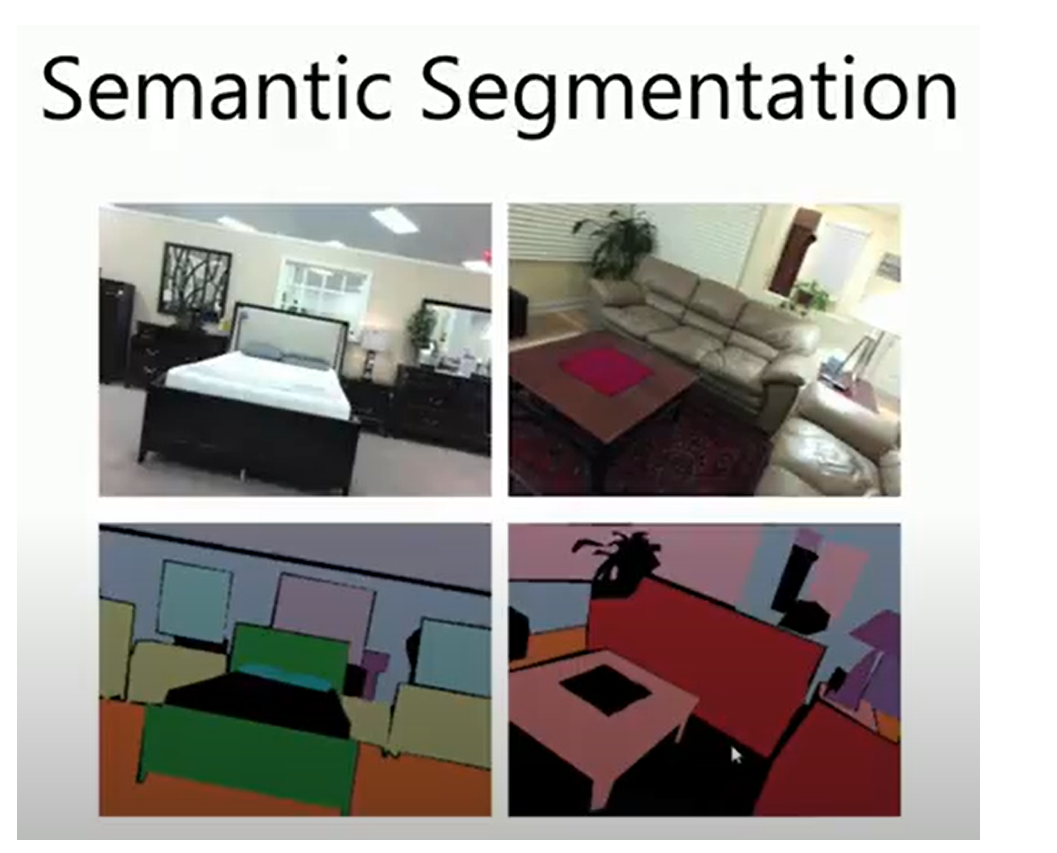

## U- Net

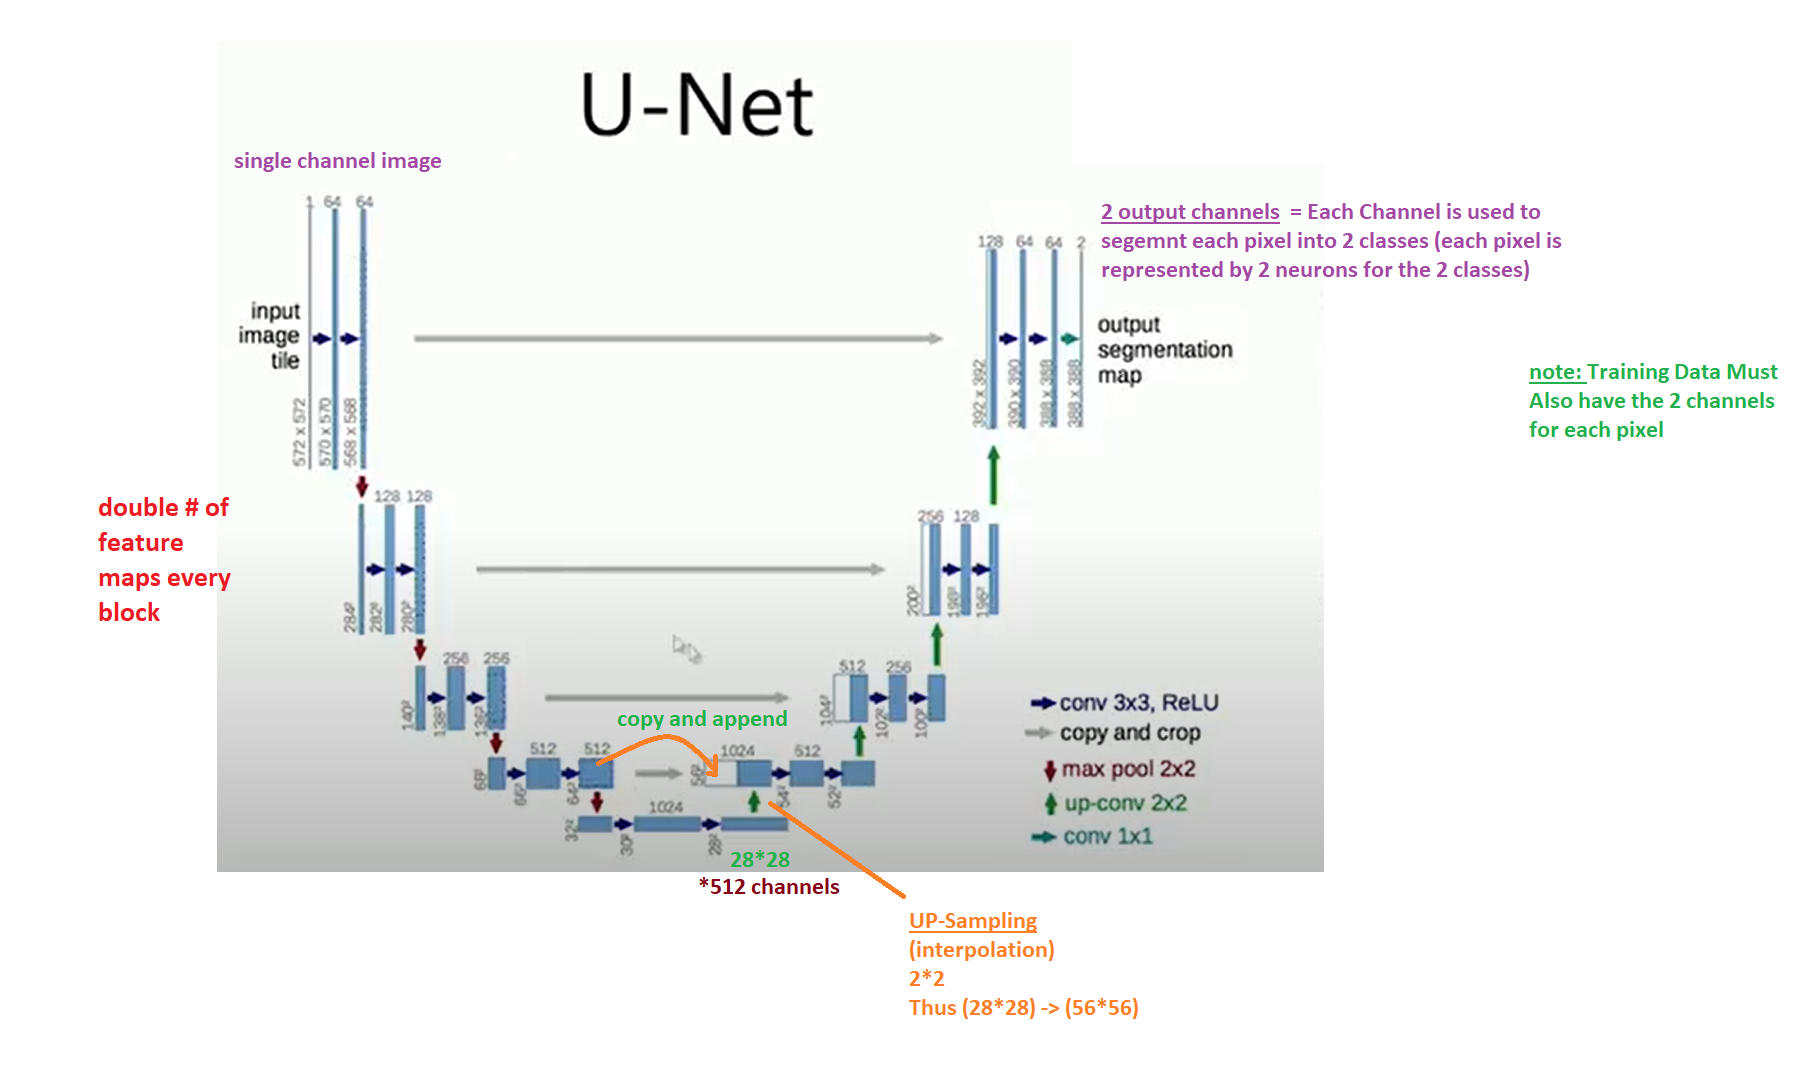

## SegNet 

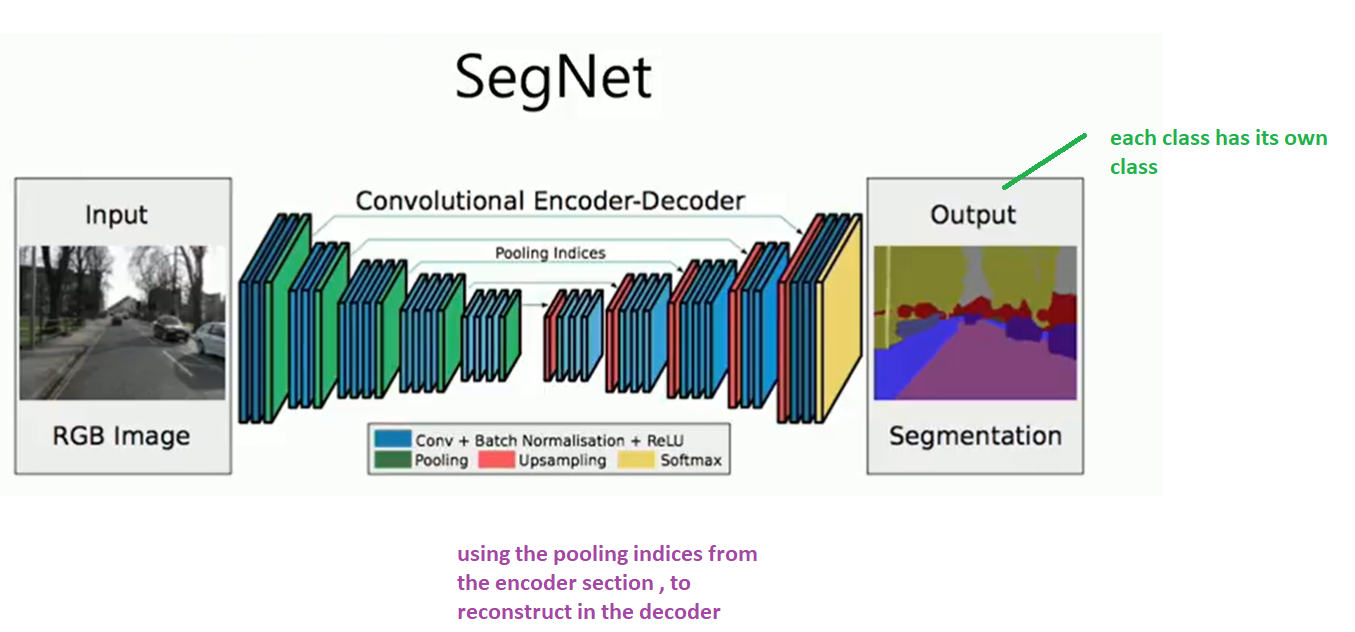

- Retina Dataset

### Import

In [1]:
%matplotlib inline
import os
import time
import tqdm
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import TensorDataset,DataLoader
import cv2
print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


### Load Data

In [9]:
trainPath = 'datasets/retina/training/'
testPath = 'datasets/retina/test/'

In [10]:
# Displaying sample image, groundtruth and mask from the dataset
sampleImg = np.array(cv2.imread(trainPath+'images/21_training.tif'))
sampleGT = np.array(Image.open(trainPath+'1st_manual/21_manual1.gif'))
sampleMask = np.array(Image.open(trainPath+'mask/21_training_mask.gif'))

Text(0.5, 1.0, 'Mask')

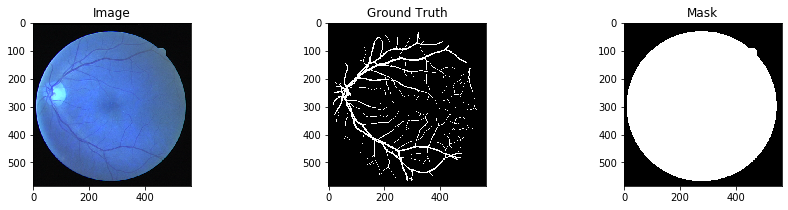

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.imshow(sampleImg)
plt.title('Image')
plt.subplot(132)
plt.imshow(sampleGT,cmap='gray')
plt.title('Ground Truth')
plt.subplot(133)
plt.imshow(sampleMask,cmap='gray')
plt.title('Mask')

In [13]:
# DRIVE dataset has 20 images for training and 20 for testing
TrainImages = torch.FloatTensor(600,3,224,224) # 20 images x 30 patches
TrainLabels = torch.FloatTensor(600,224,224)
TestImages = torch.FloatTensor(20,3,224,224)
TestLabels = torch.FloatTensor(20,224,224)

# Obtain list containing name of all files in the directoy
trainImgList = os.listdir(trainPath+'images')
testImgList = os.listdir(testPath+'images')

# Preparing train data tensors
img_no = 0
for file in trainImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = cv2.imread(trainPath+'images/'+ file)
    seg = Image.open(trainPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(trainPath+'mask/'+str(imgNum)+'_training_mask.gif')
    im = np.array(im)
    seg = np.array(seg)/255
    mask = (np.array(mask)/255-seg)
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    
    # Augmenting training data by taking 30 patches, each of size 224x224, from the original image
    randIdx1 = np.random.randint(0,im.shape[0]-224,30) 
    randIdx2 = np.random.randint(0,im.shape[1]-224,30)
    for p in range(30):
        patch = im[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224,:]/255
        seg_patch = seg[randIdx1[p]:randIdx1[p]+224,randIdx2[p]:randIdx2[p]+224]
        TrainImages[img_no] = torch.from_numpy(patch).transpose(0,2).unsqueeze(0)
        TrainLabels[img_no] = torch.from_numpy(seg_patch).transpose(0,1).unsqueeze(0)
        img_no += 1

In [14]:
# Preparing test data tensors
img_no = 0
for file in testImgList:
    imgNum = file.split('_')[0] # Image number from the filename
    im = cv2.imread(testPath+'images/'+ file)
    seg = Image.open(testPath+'1st_manual/'+str(imgNum)+'_manual1.gif')
    mask = Image.open(testPath+'mask/'+str(imgNum)+'_test_mask.gif')
    # Resizing the images to 224x224
    im = np.array(im.resize((224,224)))/255
    seg = np.array(seg.resize((224,224)))/255
    mask = (np.array(mask.resize((224,224)))-seg)/255
    idx = np.where(mask==1)
    # Note: In the GT (seg), 0--> BG, 1--> Vessels, 2--> Tissue(mask)
    seg[idx] = 2
    TestImages[img_no] = torch.from_numpy(im).transpose(0,2).unsqueeze(0)
    TestLabels[img_no] = torch.from_numpy(seg).transpose(0,1).unsqueeze(0)
    img_no += 1

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/retina/test/1st_manual/01_manual1.gif'

In [ ]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

In [ ]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 10
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True,num_workers=4, pin_memory=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False,num_workers=4, pin_memory=True)

In [ ]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

### Defining network architecture - SIMPLER MODEL

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()        
        
        # Encoder
        self.conv1c = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
                                                        ###Keep Trakc of Poolinmg Indices
        
        # Decoder
        self.mup1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.conv1d = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)    
        
    def forward(self, x):
        x = self.relu1(self.conv1c(x))
        x, idx1 = self.mp1(x)                ##### idx1 = POOLING INDICES!!
        x = self.mup1(x, idx1)           ###MaxUnpool2d takes tow arguments , image + Pooling Indices
        x = self.conv1d(x)        
        return x

### Initializing network

In [ ]:
net = SegNet()
net = net.to(device)

### Define loss function and optimizer

In [ ]:
criterion = nn.NLLLoss() # Negative Log-Likelihood
optimizer = optim.Adam(net.parameters(), lr=1e-3)

### Train the network

In [ ]:
iterations = 15
trainLoss = []
testLoss = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0   
    net.train() # For training
    for data in tqdm.tqdm_notebook(trainLoader):
        inputs,labels = data
        inputs, labels = inputs.to(device), labels.long().to(device) 
        
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(F.log_softmax(outputs,dim=1), labels)      
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.item()
    avgTrainLoss = runningLoss/(600.0 /BatchSize)   
    trainLoss.append(avgTrainLoss)
  
    
    # Evaluating performance on test set for each epoch
    net.eval() # For testing
    test_runningLoss = 0    
    with torch.no_grad():
        for data in testLoader:
            inputs,labels = data
            inputs, labels = inputs.to(device), labels.long().to(device)         
            outputs = net(inputs)       
             # Compute loss/error
            loss = criterion(F.log_softmax(outputs,dim=1), labels)      
            # Accumulate loss per batch
            test_runningLoss += loss.item() 
        
    avgTestLoss = test_runningLoss/(20.0/BatchSize)  
    testLoss.append(avgTestLoss)
        
    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [ ]:
# Visualizing segmentation on one of the test images
randIdx = np.random.randint(20)
testImg = TestImages[randIdx]
testLab = TestLabels[randIdx].numpy()

# Feed-forward 
segImg = net(testImg.unsqueeze(0).to(device))
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg,dim=1).data.squeeze(0)
if use_gpu:
    segImg_np = segImg_np.cpu()
segImg_np = segImg_np.numpy()

# Displaying segmented output and ground truth
plt.figure(figsize=(15,15))
plt.subplot(231)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
plt.subplot(232)
plt.imshow(segImg_np[1,:,:],cmap='gray')
plt.title('Channel 2')
plt.subplot(233)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')


bg = testLab==0
vessel = testLab==1
tissue = testLab==2
plt.subplot(234)
plt.imshow(bg,cmap='gray')
plt.title('Background')
plt.subplot(235)
plt.imshow(vessel,cmap='gray')
plt.title('Vessel')
plt.subplot(236)
plt.imshow(tissue,cmap='gray')
plt.title('Tissue')